In [1]:
# analyze raw pose estimation from vertical videos only and get gait metrics

# required folder structure of input folder (raw_pose_data_in_path, mirrors video folder structure)
# raw_pose_data_in_path
    # participant 1
        # date 
            # 000_raw_pose_data (folder containing pose, world, and yolo raw pose data .csv files) 
    # BW-12 
        # 2024-05-02  
            # 000_raw_pose_data (folder containing pose, world, and yolo raw pose data .csv files)

#  outputs from this analysis per patient will be saved in the same folder 

# raw_pose_data_in_path
    # participant 1
        # date 
            # 001 analysis results 
            # 002 analysis results 

# .csv for all participants in raw_pose_data_in_path saved as all_participants_pose_metrics_df variable 
    # save pose metrics from all videos in raw_pose_data_in_path saved as  
    # 'all_participants_pose_metrics_df.csv' in raw_pose_data_in_path folder 

# note! if more than one video for each task, 'gait_vertical_left_2' and 'gait_vertical_left_3'
    # if more then three videos per task, need to update 'task' variable below to include 'gait_vertical_left_3' etc 

# try for no spaces in folder and file names, but should still work if there are spaces 

# if running on large dataset, may need to run on chunks of raw pose estimation data then merge .csv files with pose metrices all, included/excluded data, etc 

In [2]:
# import libraries 
import pandas as pd 
import numpy as np 
import os 
import re

In [3]:
# import functions from sandbox src code files 
from raw_pose_analysis_funs.merge_mp_yolo_dfs import (merge_mp_pose_world, clean_mp_yolo_missing_data, add_orientation_and_turn_direction, save_merge_mp_yolo_df)
from raw_pose_analysis_funs.frames_to_time import (add_time_column, save_df_w_time)
from raw_pose_analysis_funs.landmark_visibility import (mp_vis_all_labels_boxplot, mp_vis_lineplot, mp_save_vis_stats_by_label, yolo_vis_lineplot)
from raw_pose_analysis_funs.vel_pixel_h_proxy import calc_velocity_proxy
from raw_pose_analysis_funs.select_linear_walking import select_plot_linear_walking
from raw_pose_analysis_funs.segment_video_walk_turn import (segment_video_interp_filter, segment_video_walks_turn)
from raw_pose_analysis_funs.gait_metric_stride_time import(stride_time_interp, calculate_stride_time)
from raw_pose_analysis_funs.gait_metric_cadence import (calculate_cadence)
from raw_pose_analysis_funs.gait_metric_stride_width import (stride_width_interp, calculate_stride_width)
from raw_pose_analysis_funs.gait_metric_support import (support_interp, ankle_y_vel_accel_peak_min, 
id_toe_off_heel_strike, calculate_single_double_support, create_blank_df_for_no_support)
from raw_pose_analysis_funs.gait_metrics_compile_stats import save_all_pose_metrics
from raw_pose_analysis_funs.gait_metric_support_2 import (id_calc_support_metrics, calc_support_stats) 

In [4]:
# set variables manually  

# Set input path to run all analysis 
# folder with all raw pose data (dir_in_path) 
raw_pose_data_in_path = r"C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\4. Deliverables\Dissertation\02 Technical Metric Calculations\figure data\hc_zeno\MM_HC"

# input variables for interpolation and filtering 
max_gap = 0.12 # max gap to interpolate over 
cutoff = 0.4
order = 1

In [5]:
# save list of all csv files in raw pose data folders 

raw_data_full_path_all = [] 
raw_data_file_names_all = []

# loop through all files in input path 
for (dir_path, dir_names, file_names) in os.walk(raw_pose_data_in_path):
    for file_name in file_names: 
        name, ext = os.path.splitext(file_name)
        ext = ext.lower()[1:]
        current_raw_data_in_path = os.path.join(dir_path, file_name) # full path to files 
        # save full path to file if it meets requirements to be raw pose data 
        if (ext == 'csv') & ('000_raw_pose_data' in current_raw_data_in_path): # from run.py, outputs all saved in 000_raw_pose_data_folder
            raw_data_full_path_all = raw_data_full_path_all + [current_raw_data_in_path]
            raw_data_file_names_all = raw_data_file_names_all + [file_names]

Analyzing data from: MM_HC\2024-07-30
Analyzing video_id_date_name: MM_HC_17ft_gait_vertical_right_MM_HC_2024-07-30


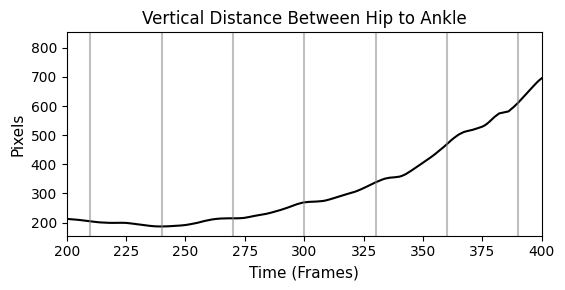

walk segment number: 0


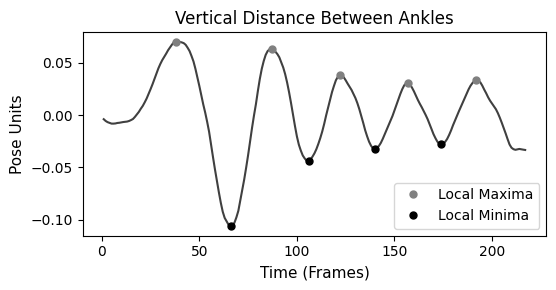

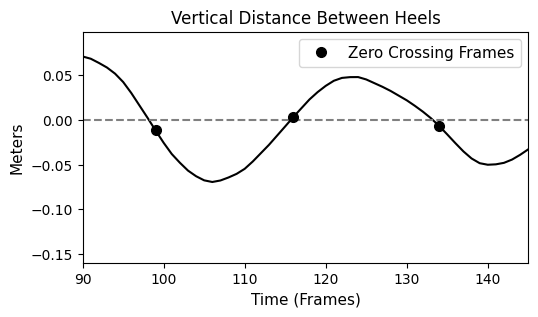

walk segment number: 1


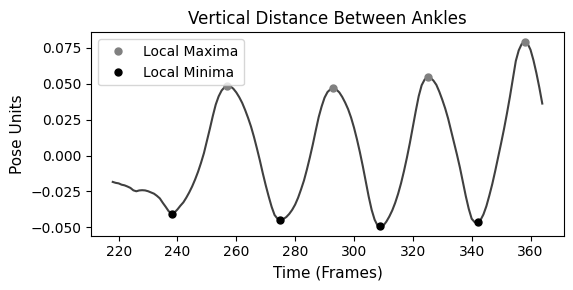

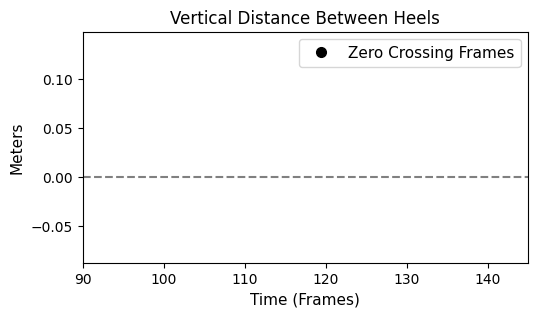

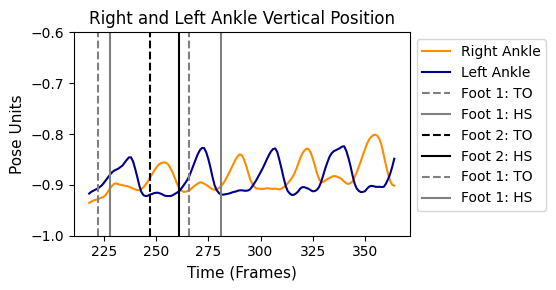

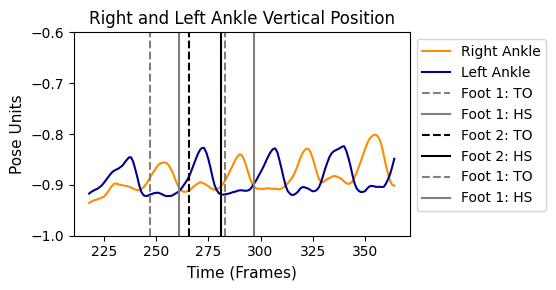

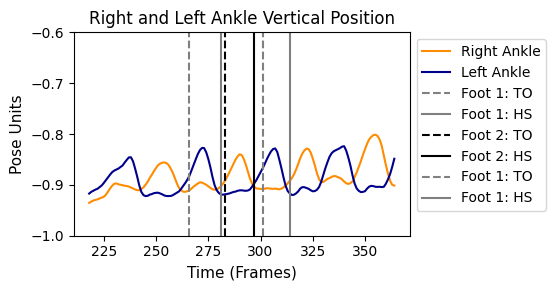

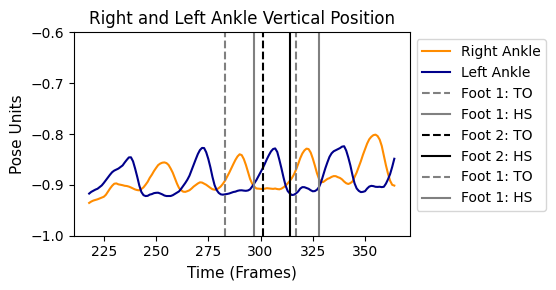

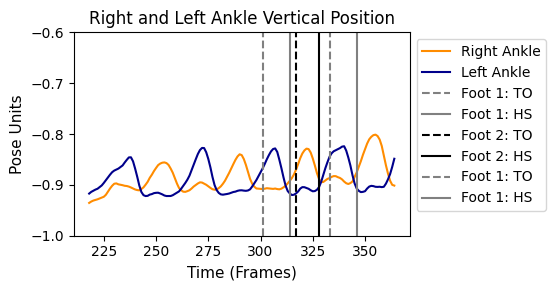

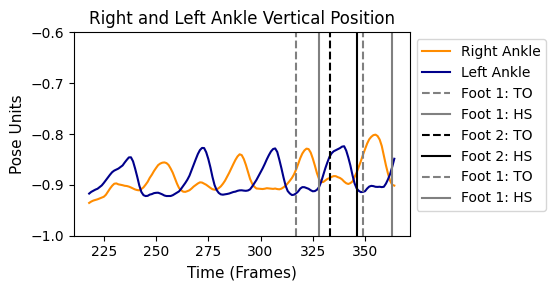

walk segment number: 2


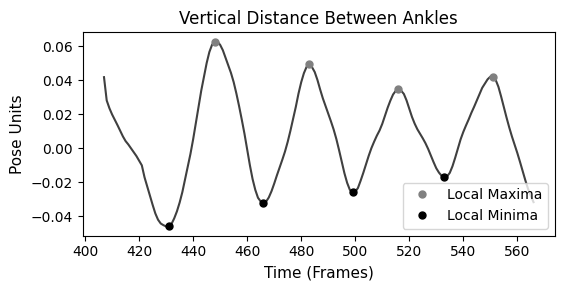

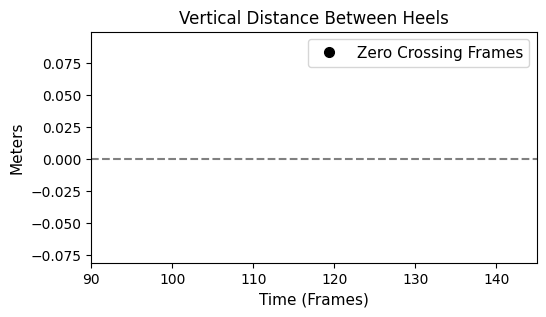

walk segment number: 3


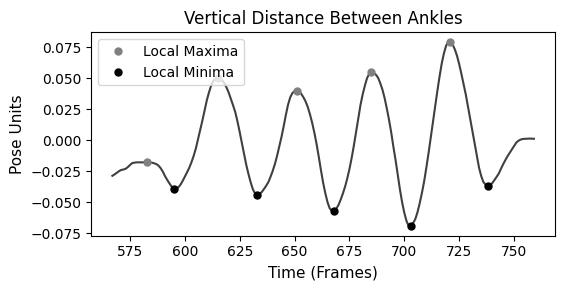

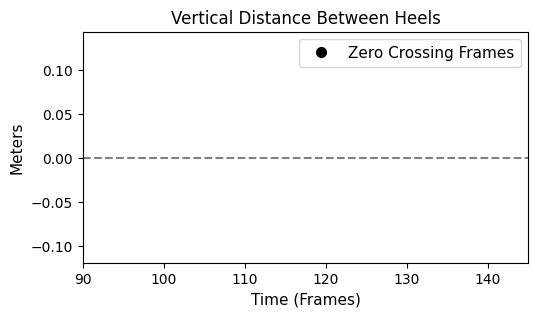

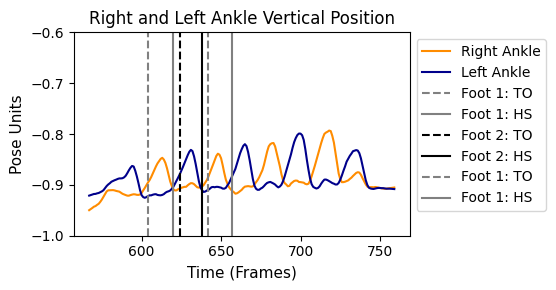

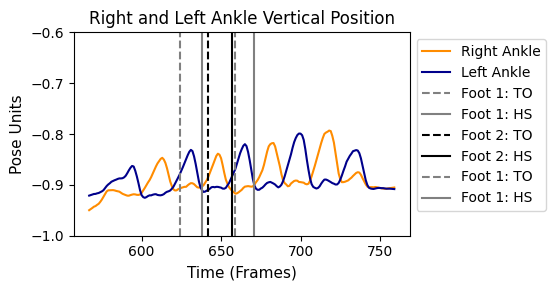

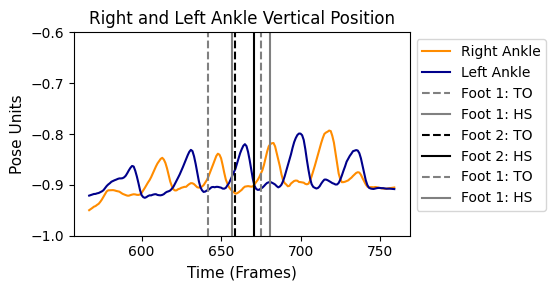

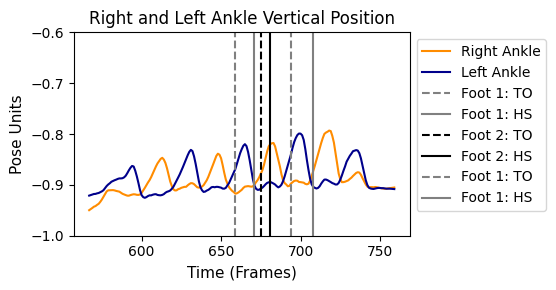

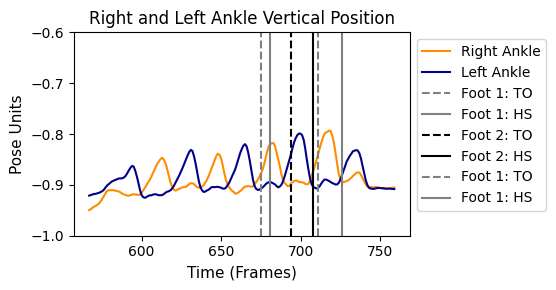

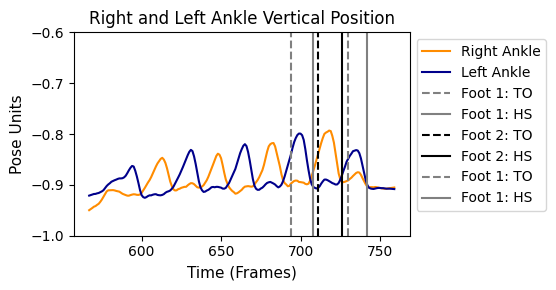

In [6]:
# find all unique ID date combos (each unique folder with videos)
id_date_all = []
for file_i, raw_path in enumerate(raw_data_full_path_all): 
    parent_path_1, current_file_name = os.path.split(raw_path)
    parent_path_2, current_raw_data_folder = os.path.split(parent_path_1)
    parent_path_3, current_date = os.path.split(parent_path_2)
    parent_path_4, current_id = os.path.split(parent_path_3)
    current_id_date = os.path.join(current_id, current_date)
    id_date_all = id_date_all + [current_id_date]

# add if statement to pick specific IDs
# if float(current_id[3:]) >= 204:
#    current_id_date = os.path.join(current_id, current_date)
#    id_date_all = id_date_all + [current_id_date]

# for each unique ID and date combo, 
#select either all gait_vertical_right .csv files or all gait_vertical_left files and run all analysis 

# all unique ID and date combos of .csv files in raw pose data folder 
unique_id_date = list(set(id_date_all))
unique_id_date = sorted(unique_id_date) # run in same order every time

# gait_vertical_left and gait_vertical_right = home videos 
# PWS, FW, and TUG = in person BW zeno videos 
tasks = ['gait_vertical_left', 
         'gait_vertical_left_2', 
         'gait_vertical_left_3',
         'gait_vertical_right', 
         'gait_vertical_right_2',
         'gait_vertical_right_3',
         'gait_vertical_PWS_1',
         'gait_vertical_PWS_2',
         'gait_vertical_FW_1', 
         'gait_vertical_FW_2',
         'gait_vertical_TUG_1',
         'gait_vertical_TUG_2'
        ] 

# set blank variables to add file names to be included or excluded 
included_videos = []
excluded_videos = []

vids_insufficient_data = []

# blank to save all velocity proxy measures 
delta_pix_h_rel_median_all = []

# blank to populate with all included participant metrics 
all_participants_pose_metrics = []

for id_date_i, id_date in enumerate(unique_id_date): 
    print('Analyzing data from: ' + id_date)
    # select raw data paths that match id_date combo 
    current_id_date_csv_file_paths = [item for item in raw_data_full_path_all if id_date in item]

    # set output folder prefix. Find relative paths relative from input folder to raw data .csv 
    raw_data_relpath = os.path.relpath(current_id_date_csv_file_paths[0], raw_pose_data_in_path)
    rel_path_to_date_subfolder, raw_data_subfolder = os.path.split(os.path.dirname(raw_data_relpath))
    dir_out_prefix = os.path.normpath(os.path.join(raw_pose_data_in_path, rel_path_to_date_subfolder))
   # print('dir_out_prefix: ' + dir_out_prefix)
    
    # select raw data paths that match right or left vertical task/video
    for task_i, task, in enumerate(tasks):  
        # select files matching current task 
        current_task_csv_paths = [item for item in current_id_date_csv_file_paths if task in item]

         # populate in later step 
        valid_segments_found = [] 
        
        # if files with raw data for this task is saved in subfolder, run analysis  
        if len(current_task_csv_paths) == 0: 
            #print('Skipped: no files matching ' + task)
            valid_segments_found = []
        elif (len(current_task_csv_paths) > 0) & (len(current_task_csv_paths) <= 3):
            valid_segments_found = []
            vids_insufficient_data.append(current_task_csv_paths[0]) # often some videos with fps but not pose data 
        else: 
            # after selecting for correct task, save each raw data path as own variable 
            current_yolo_data_path = [item for item in current_task_csv_paths if 'yolo.csv' in item]
            current_mp_pose_data_path = [item for item in current_task_csv_paths if 'mediapipe.csv' in item]
            current_mp_world_data_path = [item for item in current_task_csv_paths if 'mediapipe_world.csv' in item]
            current_video_fps_path = [item for item in current_task_csv_paths if 'fps.csv' in item]

            # # [-1]: if more than 1 'gait_vertical_right' video, 
                # make sure to select 'gait_vertical_right' (last path), not 'gait_vertical_right_2' 
            if len(current_yolo_data_path) > 1: 
                current_yolo_data_path = [sorted(current_yolo_data_path)[-1]]
            if len(current_mp_pose_data_path) > 1:
                current_mp_pose_data_path = [sorted(current_mp_pose_data_path)[-1]]
            if len(current_mp_world_data_path) > 1:
                current_mp_world_data_path = [sorted(current_mp_world_data_path)[-1]]
            if len(current_video_fps_path) > 1:
                current_video_fps_path = [sorted(current_video_fps_path)[-1]]
            
            # read in raw pose data, all three types 
            mp_pose_df = pd.read_csv(current_mp_pose_data_path[0])
            mp_world_df = pd.read_csv(current_mp_world_data_path[0])
            yolo_df = pd.read_csv(current_yolo_data_path[0])
            
            # read in frames per seconds and save as var for future code 
            fps_df = pd.read_csv(current_video_fps_path[0], index_col = 0)
            fps = fps_df.iloc[0,0]

            # set video ID - ID_date_task (analogous to vid_in_path in run script, use for plot and file names)
            yolo_basename = os.path.splitext(os.path.basename(current_yolo_data_path[0]))[0]
            video_id_date_name = (yolo_basename).replace('yolo', id_date).replace('\\', '_')
            print('Analyzing video_id_date_name: ' + video_id_date_name)
            
            # run analysis functions 
            # step 001 - merge and clean yolo and mediapipe data 
            [mp_all_df, yolo_df] = merge_mp_pose_world(mp_pose_df, mp_world_df, yolo_df)
            [mp_all_df, yolo_df] = clean_mp_yolo_missing_data(mp_all_df, yolo_df)
            [mp_all_df, yolo_df] = add_orientation_and_turn_direction(video_id_date_name, mp_all_df, yolo_df) # check vid_in_path 
            # save_merge_mp_yolo_df(mp_all_df, yolo_df, video_id_date_name, dir_out_prefix)

            # 002 frames to time: save .csv file with seconds in 003 output folder 
            [mp_all_df, yolo_df] = add_time_column(mp_all_df, yolo_df, fps)
            save_df_w_time(mp_all_df, yolo_df, video_id_date_name, dir_out_prefix) 

            # save var of total video time 
            current_vid_duration = mp_all_df['time_seconds'].iloc[-1] - mp_all_df['time_seconds'].iloc[0]

            # 003 - plot and save landmark visibility scores for yolo and mediapipe 
            # yolo 
            yolo_vis_lineplot(yolo_df, video_id_date_name, dir_out_prefix)
            # mediapipe 
            mp_vis_all_labels_boxplot(mp_all_df, video_id_date_name, dir_out_prefix) 
            mp_vis_lineplot(mp_all_df, video_id_date_name, dir_out_prefix)
            # calculate and save mean, standard deviation, and median visibility for each marker
            vis_stats_df = mp_save_vis_stats_by_label(mp_all_df, video_id_date_name, dir_out_prefix)

            # -------------------------------------
            # calculate velocity proxy for each video using yolo hip Y position from original yolo df 
            vel_output_folder = os.path.join(dir_out_prefix, '005_gait_metrics', 'vel_pixel_proxy')
            if not os.path.exists(vel_output_folder):
                os.makedirs(vel_output_folder)
            
            delta_pix_h_rel_median = calc_velocity_proxy(yolo_df, video_id_date_name, vel_output_folder, fps)
            
            # save all medians to join with all other metrics in next step 
            delta_pix_h_rel_median_all.append({'id_date_pose' : id_date,
                                              'video_id_date_name_pose' : video_id_date_name,
                                               'task_pose' : task,
                                               'frames_per_second_pose' : fps,
                                               'total_video_duration_sec_pose' : current_vid_duration,      
                                               'delta_pix_h_rel_median_pose' : delta_pix_h_rel_median})

            # ---------------------------------------------
            # 3.5  selecting linear walking, remove extraneous activity 
            valid_segments_all, valid_segments_found = select_plot_linear_walking(mp_all_df, yolo_df, fps, video_id_date_name, dir_out_prefix)
            
            # if not valid segments found, skip analysis steps and save name to exclude list 
            if valid_segments_found == 0: 
                excluded_videos.append(video_id_date_name) 
            else: # a valid segments are found, calculate metrics over each segment 
                included_videos.append(video_id_date_name)

                #005 calculate gait metrics over each walk segment 
                stride_time_stats_per_walk = pd.DataFrame()
                stride_times_all = pd.DataFrame()

                cadence_per_walk = pd.DataFrame()

                stride_width_stats_per_walk = pd.DataFrame()
                stride_width_all = pd.DataFrame()

                support_metric_stats_per_walk = pd.DataFrame()
                support_metrics_all = pd.DataFrame() 

                for segment_i, current_segment in enumerate(valid_segments_all):
                    print('walk segment number: ' + str(segment_i))
                    start_sec = current_segment['time_seconds'].iloc[0]
                    end_sec = current_segment['time_seconds'].iloc[-1]
                    
                    # select yolo and mediapipe df between end and start seconds 
                    current_mp_all_df = mp_all_df[(mp_all_df['time_seconds'] >= start_sec) & (mp_all_df['time_seconds'] <= end_sec)]
                    current_segment_yolo_df = yolo_df[(yolo_df['time_seconds'] >= start_sec) & (yolo_df['time_seconds'] <= end_sec)]
            
                    #stride time ------------------------------
                    mp_ankle_Y_interp = stride_time_interp(current_mp_all_df, video_id_date_name, dir_out_prefix, max_gap, fps)
                    [stride_time_stats_df, stride_times_peaks, stride_times_valleys] = calculate_stride_time(mp_ankle_Y_interp, fps,
                                                                                                     video_id_date_name, dir_out_prefix,
                                                                                                     rolling_mean_window = round(.5 * fps), 
                                                                                                     find_peaks_distance = round(.33 * fps), # min distance between ankle y distance peaks (frames) 
                                                                                                     find_peaks_prominence = 0.01, # ankle y peaks need to be greater than this value to count as step
                                                                                                     walk_num = str(segment_i))
                    # save stride time stats per walking segment 
                    stride_time_stats_per_walk = pd.concat([stride_time_stats_per_walk, stride_time_stats_df])
                    
                    # join times from peaks and valleys 
                    peak_and_valley_times = pd.concat([pd.DataFrame(stride_times_peaks), pd.DataFrame(stride_times_valleys)]) # all times for one walk
                    stride_times_all = pd.concat([stride_times_all, peak_and_valley_times])

                    # cadence --------------------------------------
                    total_steps, video_length_sec, cadence_df = calculate_cadence(stride_times_peaks, stride_times_valleys,
                                                                                    start_sec, end_sec,
                                                                                    video_id_date_name, dir_out_prefix)
                    # save cadence for each segment 
                    cadence_per_walk = pd.concat([cadence_per_walk, cadence_df])

                    # stride width ---------------------------------
                    mp_stride_width_interp_dfs = stride_width_interp(current_mp_all_df, video_id_date_name, dir_out_prefix, max_gap, fps)
                    stride_width_stats_df, stride_width = calculate_stride_width(mp_stride_width_interp_dfs, 
                                                                                 video_id_date_name, 
                                                                                 dir_out_prefix, 
                                                                                 walk_num = str(segment_i))
                    # save stride width stats per walking segment 
                    stride_width_stats_per_walk = pd.concat([stride_width_stats_per_walk, stride_width_stats_df])
                    
                    # save stride widths for all segments 
                    stride_width_all = pd.concat([stride_width_all, stride_width])

                    # single and double support ----------------------------------------
                    # if participant is moving toward camera 
                    if (current_segment['pattern'] == 'increasing').all(): 
#                        print('increasing - calc support')
                        metrics_per_stride_df = id_calc_support_metrics(current_mp_all_df, fps, video_id_date_name, dir_out_prefix, walk_num = str(segment_i))

                        # if at least one stride with data, calculate stats and append to per walk 
                        support_metric_stats_df = calc_support_stats(metrics_per_stride_df)

                        # save suport stats per walking segment 
                        support_metric_stats_per_walk = pd.concat([support_metric_stats_per_walk, support_metric_stats_df]) 

                        # save support metrics per stride for all segments 
                        support_metrics_all = pd.concat([support_metrics_all, metrics_per_stride_df]) 

                # ----------------------------------------------------------------
                # save results for each walking segment and for all walking segments combined 
                vid_in_path_no_ext = os.path.splitext(os.path.basename(video_id_date_name))[0]
                
                # stride time  
                # each row = 1 walk segment 
                stride_time_output = os.path.join(dir_out_prefix, '005_gait_metrics', 'stride_time')
                stride_time_stats_path = os.path.normpath(os.path.join(stride_time_output, (vid_in_path_no_ext + '_stride_time_stats_per_walk.csv')))
                stride_time_stats_per_walk.to_csv(stride_time_stats_path)

                # save stride time summary stats for all strides in all walking segments 
                stride_time_stats_all = pd.DataFrame(data = {'stride_time_mean_sec' : [stride_times_all['seconds'].mean(skipna = True)], 
                                                             'stride_time_median_sec': [stride_times_all['seconds'].median(skipna = True)], 
                                                             'stride_time_std' : [stride_times_all['seconds'].std(skipna = True)], 
                                                             'stride_time_cv' : [(stride_times_all['seconds'].std(skipna = True) / 
                                                                                   stride_times_all['seconds'].mean(skipna = True)) * 100],
                                                             'stride_time_max' : [stride_times_all['seconds'].max(skipna = True)],
                                                             'stride_time_min' : [stride_times_all['seconds'].min(skipna = True)]
                                                            })
                stride_time_all_stats_path = os.path.normpath(os.path.join(stride_time_output, (vid_in_path_no_ext + '_stride_time_stats_all.csv')))
                stride_time_stats_all.to_csv(stride_time_all_stats_path)

                # cadence 
                cadence_output_folder = os.path.join(dir_out_prefix, '005_gait_metrics', 'cadence')
                if not os.path.exists(cadence_output_folder):
                    os.makedirs(cadence_output_folder)
                
                # each row = cadence from 1 walk  
                cadence_per_walk_path = os.path.normpath(os.path.join(cadence_output_folder, (vid_in_path_no_ext + '_cadence_per_walk.csv')))
                cadence_per_walk.to_csv(cadence_per_walk_path)

                # mean of cadence from all walk segments 
                cadence_mean_df = pd.DataFrame(index = range(1), 
                                               data = {'mean_cadence_step_per_min' : cadence_per_walk['cadence_step_per_min'].mean(skipna = True)})
                cadence_mean_path = os.path.normpath(os.path.join(cadence_output_folder, (vid_in_path_no_ext + '_mean_cadence.csv')))
                cadence_mean_df.to_csv(cadence_mean_path)

                # stride width 
                width_output_folder = os.path.join(dir_out_prefix, '005_gait_metrics', 'stride_width')
                if not os.path.exists(width_output_folder):
                    os.makedirs(width_output_folder)

                # save stats = each row = 1 walk 
                stride_width_stats_path = os.path.normpath(os.path.join(width_output_folder, (vid_in_path_no_ext + '_stride_width_stats_per_walk.csv')))
                stride_width_stats_per_walk.to_csv(stride_width_stats_path)

                # stats across all walks 
                stride_width_stats_all = pd.DataFrame(data = {'stride_width_mean_cm' : [stride_width_all['heel_x_diff_0'].mean(skipna = True)],
                                                              'stride_width_median_cm' : [stride_width_all['heel_x_diff_0'].median(skipna = True)],
                                                              'stride_width_std' : [stride_width_all['heel_x_diff_0'].std(skipna = True)], 
                                                              'stride_width_cv' : [(stride_width_all['heel_x_diff_0'].std(skipna = True) / 
                                                                                    stride_width_all['heel_x_diff_0'].mean(skipna = True)) * 100],
                                                              'stride_width_max' : [stride_width_all['heel_x_diff_0'].max(skipna = True)],
                                                              'stride_width_min' : [stride_width_all['heel_x_diff_0'].min(skipna = True)]
                                                              })
                
                stride_width_all_stats_path = os.path.normpath(os.path.join(width_output_folder, (vid_in_path_no_ext + '_stride_width_stats_all.csv')))
                stride_width_stats_all.to_csv(stride_width_all_stats_path)

                # double + single support  
                support_output_folder = os.path.join(dir_out_prefix, '005_gait_metrics', 'support_v2')
                if not os.path.exists(support_output_folder):
                    os.makedirs(support_output_folder)

                # one row per walk 
                support_metrics_per_walk_path = os.path.normpath(os.path.join(support_output_folder, (vid_in_path_no_ext + '_support_metrics_stats_per_walk.csv')))
                support_metric_stats_per_walk.to_csv(support_metrics_per_walk_path)

                # support metrics stats for all strides in the trial 
                support_metrics_stats_all = calc_support_stats(support_metrics_all)
                
                support_metrics_all_stats_path =  os.path.normpath(os.path.join(support_output_folder, (vid_in_path_no_ext + '_support_metrics_stats_all.csv')))
                support_metrics_stats_all.to_csv(support_metrics_all_stats_path)
                    
        # if valid segments found, compile all metrics stats for one participant into one .csv and save for all participants df 
        if valid_segments_found == 1:
            pose_metrics_df = save_all_pose_metrics(video_id_date_name,
                                                    valid_segments_all,
                                                    stride_time_stats_all, 
                                                    cadence_mean_df, 
                                                    stride_time_stats_df, 
                                                    stride_width_stats_all,
                                                    support_metrics_stats_all,
                                                    dir_out_prefix)

            all_participants_pose_metrics.append(pose_metrics_df) 

In [7]:
raw_parent, all_gait_metrics_filename = os.path.split(raw_pose_data_in_path)

# save file on included vs excluded walks - gait metric calculations (stride time, cadence, etc) 
excluded_videos_df = pd.DataFrame(data = {'excluded_vids' : excluded_videos})
excluded_videos_df.to_csv(os.path.join(raw_pose_data_in_path, (all_gait_metrics_filename + '_excluded_videos.csv')))

included_videos_df = pd.DataFrame(data = {'included_vids' : included_videos})
included_videos_df.to_csv(os.path.join(raw_pose_data_in_path, (all_gait_metrics_filename + '_included_videos.csv')))

# save list of videos without enough .csv input files for analysis (often have fps but missing pose data) 
vids_insufficient_data_df = pd.DataFrame(data = {'vids_insufficient_data' : vids_insufficient_data})
vids_insufficient_data_df.to_csv(os.path.join(raw_pose_data_in_path, (all_gait_metrics_filename + '_insufficient_data_for_gait_analysis.csv')))

In [8]:
# all participants with gait metrics - stride time, cadence, width, and support 
all_participants_pose_metrics_df = pd.concat(all_participants_pose_metrics, ignore_index = True)
all_participants_pose_metrics_df = all_participants_pose_metrics_df.set_index('video_id_date_name_pose')
all_participants_pose_metrics_df.to_csv(os.path.join(raw_pose_data_in_path, (all_gait_metrics_filename + '_gait_metrics_only.csv')))

all_participants_pose_metrics_df.head()

,walking_segmets_n_pose,walking_segments_duration_mean_pose,walking_segments_duration_median_pose,stride_time_mean_sec_pose,stride_time_median_sec_pose,stride_time_std_pose,stride_time_cv_pose,stride_time_max_pose,stride_time_min_pose,mean_cadence_step_per_min_pose,...,singlesupport_per_std_pose,singlesupport_time_sec_std_pose,stance_time_per_std_pose,stance_time_sec_std_pose,swing_time_per_std_pose,swing_time_sec_std_pose,term_dsupport_sec_std_pose,tot_dsupport_per_std_pose,tot_dsupport_time_sec_std_pose,y_cross_row_index_std_pose
video_id_date_name_pose,,,,,,,,,,,,,,,,,,,,,
MM_HC_17ft_gait_vertical_right_MM_HC_2024-07-30,4,5.94,5.85,1.177,1.167,0.108,9.191,1.633,1.067,99.826,...,9.3,0.08,4.95,0.19,4.95,0.08,0.1,9.97,0.19,1.86


In [9]:
# all participants with veloicty proxy using change in pixel position  
delta_pix_h_rel_median_all_df = pd.DataFrame(delta_pix_h_rel_median_all)
delta_pix_h_rel_median_all_df = delta_pix_h_rel_median_all_df.set_index('video_id_date_name_pose')
delta_pix_h_rel_median_all_df.head()

delta_pix_h_rel_median_all_df.to_csv(os.path.join(raw_pose_data_in_path, (all_gait_metrics_filename + '_vel_proxy_only.csv')))

In [10]:
# gait metrics and velocity proxy measures into one dataframe 
joined_df = delta_pix_h_rel_median_all_df.join(all_participants_pose_metrics_df, 
                                                  on = 'video_id_date_name_pose', 
                                                  how = 'left')

joined_df = joined_df.reset_index()

joined_df.to_csv(os.path.join(raw_pose_data_in_path, (all_gait_metrics_filename + '_pose_metrics_all.csv')))
print('Saving ' +  os.path.join(raw_pose_data_in_path, (all_gait_metrics_filename + '_pose_metrics_all.csv')))

Saving C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\4. Deliverables\Dissertation\02 Technical Metric Calculations\figure data\hc_zeno\MM_HC\MM_HC_pose_metrics_all.csv


In [11]:
print('number of vids_insufficient_data_df')
print(len(vids_insufficient_data_df))

print('number of excluded_videos_df')
print(len(excluded_videos_df))

print('number of included_videos_df')
print(len(included_videos_df))

number of vids_insufficient_data_df
0
number of excluded_videos_df
0
number of included_videos_df
1
